<a href="https://colab.research.google.com/github/egonik-unlp/random_projects/blob/master/data_analytics/dataset_kaggle_DA_metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Procesamiento del Dataset Hazardous Air Pollutants {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Carga de datos desde Kaggle

Primero para poder trabajar, cargamos nuestra clave de API de kaggle y activamos la libreria

In [2]:
from google.colab import files
!wget https://raw.githubusercontent.com/egonik-unlp/random_projects/master/data_analytics/kaggle.json
!mkdir /root/.kaggle 
!cp kaggle.json /root/.kaggle
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json


--2021-04-15 14:32:02--  https://raw.githubusercontent.com/egonik-unlp/random_projects/master/data_analytics/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      68  --.-KB/s    in 0s      

2021-04-15 14:32:02 (1.99 MB/s) - ‘kaggle.json’ saved [68/68]



Luego descargamos el dataset y lo descomprimimos en la carpeta datasets

In [3]:
!kaggle datasets metadata  'epa/hazardous-air-pollutants'
!cat /content/dataset-metadata.json

Downloaded metadata to /content/dataset-metadata.json
{
  "subtitle": "A summary of daily Hazardous Air Pollutants from 1990 to 2017", 
  "description": "###Context: \nHazardous air pollutants, also known as toxic air pollutants or air toxics, are those pollutants that are known or suspected to cause cancer or other serious health effects, such as reproductive effects or birth defects, or adverse environmental effects. The Environmental Protection Agency (EPA) tracks 187 air pollutants. See [https://www.epa.gov/haps/](https://www.epa.gov/haps/) for more information.\n\n\n###Content: \nThe daily summary file contains data for every monitor (sampled parameter) in the Environmental Protection Agency (EPA) database for each day. This file will contain a daily summary record that is:\n1. The aggregate of all sub-daily measurements taken at the monitor.\n2. The single sample value if the monitor takes a single, daily sample (e.g., there is only one sample with a 24-hour duration). In this ca

In [4]:
!kaggle datasets download -d 'epa/hazardous-air-pollutants'
!unzip /content/hazardous-air-pollutants.zip -d /content/dataset

100% 557M/558M [00:07<00:00, 79.3MB/s]
100% 558M/558M [00:07<00:00, 81.0MB/s]
Archive:  /content/hazardous-air-pollutants.zip
  inflating: /content/dataset/epa_hap_daily_summary.csv  


Importamos las librerias que nos serán útiles para procesar los datos

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display as d
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
np.random.seed(42)

Cargamos el dataset como un DataFrame de pandas

In [6]:
# Es muy pesado de cargar, lo pongo en una celda individual para asegurarme de que no se corra dos veces
df = pd.read_csv('dataset/epa_hap_daily_summary.csv')

Renombramos columnas

In [7]:
df.rename( columns={
    'state_code': 'state_id',
    'county_code':'county_id',
    'parameter_code':'parameter_id',
    'method_code':'method_id',
    'site_num': 'site_id',
    'date_local':'sample_date',
}, inplace = True)

Como cada instancia de la tabla es una medición, definimos el sample_id como el nro de row de la tabla (index)

In [8]:
df['sample_id'] = df.index

Concatenamos los ids de entidades débiles para generar ids únicos

In [9]:
#preparacion para generar datos unicos

x,y = df[['state_id','county_id' ]].astype(str).iteritems()
df['county_unique_id'] = x[1] + y[1]
x,y = df[['county_unique_id','site_id' ]].astype(str).iteritems()
df['site_unique_id'] = x[1] + y[1]

El dataset original tiene aproximadamente $8 x 10^6$ instancias, que lo hacen muy dificil de usar. Desde ahora en adelante usaremos una fracción del dataset. Para ello elegimos rows al azar.


In [10]:
def remove_n_rows(N:int, dataframe:pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
  '''
  N representa la fraccion en la que quiero reducir el dataframe
  '''

  number_of_rows = len(dataframe) -  int(len(dataframe)/N)
  drop_indices = np.random.choice(dataframe.index ,number_of_rows,replace = False)
  d(md(f'El dataframe original tenia {len(dataframe)} rows, se redujeron a {len(dataframe) - len(drop_indices)}' ))
  return dataframe.drop(drop_indices)

df2 = remove_n_rows(15.01,df)

El dataframe original tenia 8097069 rows, se redujeron a 539444

Separamos las columnas del dataset para representar la estructura de la base de datos. Esta estructura está de acuerdo con el siguiente diagrama ER:
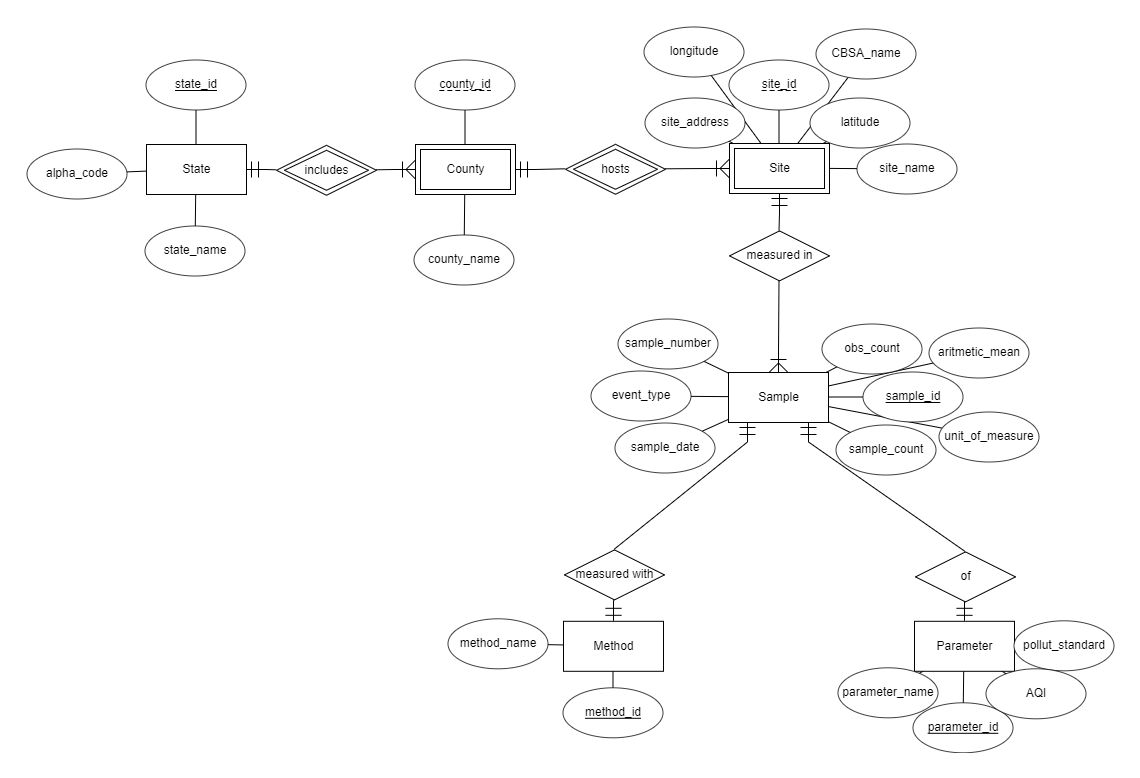

In [11]:
state = df2[[
            'state_name',
            'state_id'
]].copy()

county= df2[[
          'county_unique_id',
          'county_name',
          'state_id'
]].copy()

site = df2[[
         'address',
         'city_name',
         'cbsa_name',
         'county_unique_id',
         'site_unique_id'
]].copy()

sample = df2[[
           'sample_id',
           'sample_duration',
           'sample_date',
           'units_of_measure',
           'event_type',
           'observation_count',
           'arithmetic_mean',
           'site_unique_id',
           'parameter_id',
           'method_id'
]].copy()

parameter = df2[[
              'parameter_id',
              'parameter_name'
]].copy()

method = df2[[
           'method_id',
           'method_name'
]].copy()

Aún la estructura de la base de datos no está completa, ya que todas las tablas (a excepcion de la de mediciones) tendrá valores repetidos, correspondientes a la cada una de las medidas. Por ejemplo, la tabla states (donde cada instancia debería representar un estado) tiene tantas entradas como medidas se realizaron. Esto no tiene sentido, por ello nos quedaremos solo con los valores únicos de cada tabla, identificados por el ID.


In [12]:
method.drop_duplicates('method_id', inplace = True)
state.drop_duplicates('state_id', inplace = True)
sample.drop_duplicates('sample_id', inplace = True)
parameter.drop_duplicates('parameter_id', inplace = True)
county.drop_duplicates('county_unique_id', inplace = True)
site.drop_duplicates('site_unique_id', inplace = True)
state['alpha_code'] = state['state_name'].map(us_state_abbrev)
state.replace(np.nan, '-', inplace = True)

Exportamos el dataset como un archivo de excel, con pestañas representando las distintas tablas.

In [13]:
def save_xls(list_dfs:list, xls_path:str, list_names:list) -> str:
    with pd.ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,list_names[n], index = False)
        writer.save()
dfs = [state, county,site, sample, parameter, method]
dfs_names = ['state', 'county','site', 'sample', 'parameter', 'method']






save_xls(dfs, f'database_{len(df2)}.xlsx', dfs_names)

In [14]:
import json
with open('dataset-metadata.json', 'r') as file:
  metadata = json.load(file)

metadata

{'description': '###Context: \nHazardous air pollutants, also known as toxic air pollutants or air toxics, are those pollutants that are known or suspected to cause cancer or other serious health effects, such as reproductive effects or birth defects, or adverse environmental effects. The Environmental Protection Agency (EPA) tracks 187 air pollutants. See [https://www.epa.gov/haps/](https://www.epa.gov/haps/) for more information.\n\n\n###Content: \nThe daily summary file contains data for every monitor (sampled parameter) in the Environmental Protection Agency (EPA) database for each day. This file will contain a daily summary record that is:\n1. The aggregate of all sub-daily measurements taken at the monitor.\n2. The single sample value if the monitor takes a single, daily sample (e.g., there is only one sample with a 24-hour duration). In this case, the mean and max daily sample will have the same value.\n\n\n**Fields Descriptions:**\n1. State Code: The Federal Information Process

In [16]:
with open('codigo.md', 'w') as file:
  file.write(metadata['description'])
d(md(metadata['description']))

###Context: 
Hazardous air pollutants, also known as toxic air pollutants or air toxics, are those pollutants that are known or suspected to cause cancer or other serious health effects, such as reproductive effects or birth defects, or adverse environmental effects. The Environmental Protection Agency (EPA) tracks 187 air pollutants. See [https://www.epa.gov/haps/](https://www.epa.gov/haps/) for more information.


###Content: 
The daily summary file contains data for every monitor (sampled parameter) in the Environmental Protection Agency (EPA) database for each day. This file will contain a daily summary record that is:
1. The aggregate of all sub-daily measurements taken at the monitor.
2. The single sample value if the monitor takes a single, daily sample (e.g., there is only one sample with a 24-hour duration). In this case, the mean and max daily sample will have the same value.


**Fields Descriptions:**
1. State Code: The Federal Information Processing Standards (FIPS) code of the state in which the monitor resides.

2. County Code: The FIPS code of the county in which the monitor resides.

3. Site Num: A unique number within the county identifying the site.

4. Parameter Code: The AQS code corresponding to the parameter measured by the monitor.

5. POC: This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.

6. Latitude: The monitoring site’s angular distance north of the equator measured in decimal degrees.

7. Longitude: The monitoring site’s angular distance east of the prime meridian measured in decimal degrees.

8. Datum: The Datum associated with the Latitude and Longitude measures.

9. Parameter Name: The name or description assigned in AQS to the parameter measured by the monitor. Parameters may be pollutants or non-pollutants.

10. Sample Duration: The length of time that air passes through the monitoring device before it is analyzed (measured). So, it represents an averaging period in the atmosphere (for example, a 24-hour sample duration draws ambient air over a collection filter for 24 straight hours). For continuous monitors, it can represent an averaging time of many samples (for example, a 1-hour value may be the average of four one-minute samples collected during each quarter of the hour).

11. Pollutant Standard: A description of the ambient air quality standard rules used to aggregate statistics. (See description at beginning of document.)

12. Date Local: The calendar date for the summary. All daily summaries are for the local standard day (midnight to midnight) at the monitor.

13. Units of Measure: The unit of measure for the parameter. QAD always returns data in the standard units for the parameter. Submitters are allowed to report data in any unit and EPA converts to a standard unit so that we may use the data in calculations.

14. Event Type: Indicates whether data measured during exceptional events are included in the summary. A wildfire is an example of an exceptional event; it is something that affects air quality, but the local agency has no control over. No Events means no events occurred. Events Included means events occurred and the data from them is included in the summary. Events Excluded means that events occurred but data form them is excluded from the summary. Concurred Events Excluded means that events occurred but only EPA concurred exclusions are removed from the summary. If an event occurred for the parameter in question, the data will have multiple records for each monitor.

15. Observation Count: The number of observations (samples) taken during the day.

16. Observation Percent: The percent representing the number of observations taken with respect to the number scheduled to be taken during the day. This is only calculated for monitors where measurements are required (e.g., only certain parameters).

17. Arithmetic Mean: The average (arithmetic mean) value for the day.

18. 1st Max Value: The highest value for the day.

19. 1st Max Hour: The hour (on a 24-hour clock) when the highest value for the day (the previous field) was taken.

20. AQI: The Air Quality Index for the day for the pollutant, if applicable.

21. Method Code:  An internal system code indicating the method (processes, equipment, and protocols) used in gathering and measuring the sample. The method name is in the next column.

22. Method Name: A short description of the processes, equipment, and protocols used in gathering and measuring the sample.

23. Local Site Name: The name of the site (if any) given by the State, local, or tribal air pollution control agency that operates it.

24. Address: The approximate street address of the monitoring site.

25. State Name: The name of the state where the monitoring site is located.

26. County Name: The name of the county where the monitoring site is located.

27. City Name: The name of the city where the monitoring site is located. This represents the legal incorporated boundaries of cities and not urban areas.

28. CBSA Name: The name of the core bases statistical area (metropolitan area) where the monitoring site is located.

29. Date of Last Change: The date the last time any numeric values in this record were updated in the AQS data system.


###Acknowledgements:
These data came from the EPA and are current up to May 01, 2017. You can use Kernels to analyze, share, and discuss this data on Kaggle, but if you’re looking for real-time updates and bigger data, check out the data on BigQuery, too: [https://cloud.google.com/bigquery/public-data/epa](https://cloud.google.com/bigquery/public-data/epa).

###Inspiration: 
People exposed to toxic air pollutants at sufficient concentrations and durations may have an increased chance of getting cancer or experiencing other serious health effects. These health effects can include damage to the immune system, as well as neurological, reproductive (e.g., reduced fertility), developmental, respiratory and other health problems. In addition to exposure from breathing air toxics, some toxic air pollutants such as mercury can deposit onto soils or surface waters, where they are taken up by plants and ingested by animals and are eventually magnified up through the food chain. Like humans, animals may experience health problems if exposed to sufficient quantities of air toxics over time. Use this dataset to find out where the highest concentrations of hazardous air pollutants are for each state. You could also use the GPS locations to find out where the EPA has the most monitoring stations and identify places that could use more.